<a href="https://colab.research.google.com/github/basilpaul7/Bi-Directional-Braille-Communication/blob/main/Braille_Text_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
from shutil import copyfile

In [3]:
os.mkdir('./images/')
alpha = 'a'
for i in range(0, 26): 
    os.mkdir('./images/' + alpha)
    alpha = chr(ord(alpha) + 1)

rootdir = '/content/drive/MyDrive/Personal/Main Project/Braille Dataset/'
for file in os.listdir(rootdir):
    letter = file[0]
    copyfile(rootdir+file, './images/' + letter + '/' + file)

In [4]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=20,
                             shear_range=10,
                             validation_split=0.2)

train_generator = datagen.flow_from_directory('./images/',
                                              target_size=(28,28),
                                              subset='training')

val_generator = datagen.flow_from_directory('./images/',
                                            target_size=(28,28),
                                            subset='validation')

Found 1248 images belonging to 26 classes.
Found 312 images belonging to 26 classes.


In [5]:
from keras import backend as K
from keras import layers as L
from keras.models import Model,load_model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

K.clear_session()

model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
reduce_lr = ReduceLROnPlateau(patience=8,verbose=0)
early_stop = EarlyStopping(patience=15,verbose=1)

entry = L.Input(shape=(28,28,3))
x = L.SeparableConv2D(64,(3,3),activation='relu')(entry)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(128,(3,3),activation='relu')(x)
x = L.MaxPooling2D((2,2))(x)
x = L.SeparableConv2D(256,(2,2),activation='relu')(x)
x = L.GlobalMaxPooling2D()(x)
x = L.Dense(256)(x)
x = L.LeakyReLU()(x)
x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
x = L.LeakyReLU()(x)
x = L.Dense(26,activation='softmax')(x)

model = Model(entry,x)
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit_generator(train_generator,
                              validation_data=val_generator,
                              epochs=666,
                              callbacks=[model_ckpt,reduce_lr,early_stop],
                              verbose=1)

Epoch 1/666


<ipython-input-5-709140038fe6>:29: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


39/39 [==============================] - 9s 40ms/step - loss: 3.3085 - accuracy: 0.0385 - val_loss: 3.2634 - val_accuracy: 0.0801 - lr: 0.0010
Epoch 2/666
39/39 [==============================] - 1s 31ms/step - loss: 3.2225 - accuracy: 0.0673 - val_loss: 3.1288 - val_accuracy: 0.1026 - lr: 0.0010
Epoch 3/666
39/39 [==============================] - 2s 42ms/step - loss: 3.0041 - accuracy: 0.1218 - val_loss: 2.7243 - val_accuracy: 0.3173 - lr: 0.0010
Epoch 4/666
39/39 [==============================] - 1s 33ms/step - loss: 2.5969 - accuracy: 0.2452 - val_loss: 2.3763 - val_accuracy: 0.2564 - lr: 0.0010
Epoch 5/666
39/39 [==============================] - 1s 32ms/step - loss: 2.1447 - accuracy: 0.3638 - val_loss: 1.6854 - val_accuracy: 0.5032 - lr: 0.0010
Epoch 6/666
39/39 [==============================] - 1s 32ms/step - loss: 1.6626 - accuracy: 0.5312 - val_loss: 1.4340 - val_accuracy: 0.5641 - lr: 0.0010
Epoch 7/666
39/39 [==============================] - 1s 31ms/step - loss: 1.3292 -

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 separable_conv2d (Separable  (None, 26, 26, 64)       283       
 Conv2D)                                                         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 separable_conv2d_1 (Separab  (None, 11, 11, 128)      8896      
 leConv2D)                                                       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                         

In [7]:
model = load_model('BrailleNet.h5')
acc = model.evaluate_generator(val_generator)[1]
print('model accuracy: {}'.format(round(acc,4)))

<ipython-input-7-11a8187ef6d0>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = model.evaluate_generator(val_generator)[1]


model accuracy: 0.9487


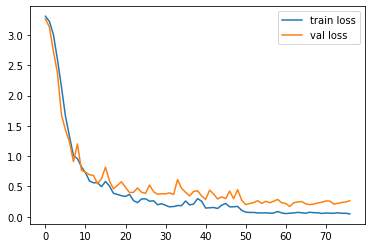

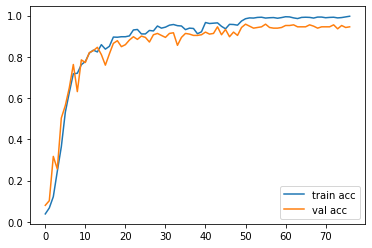

<Figure size 432x288 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

[[[254. 254. 254.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [254. 254. 254.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[252. 252. 252.]
  [253. 253. 253.]
  [254. 254. 254.]
  ...
  [254. 254. 254.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [254. 254. 254.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[252. 252. 252.]
  [253. 253. 253.]
  [253. 253. 253.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]]
(28, 28, 3)
1/1 [==============================] - 0s 39ms/step
j


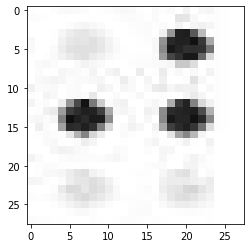

In [18]:
from tensorflow.keras.preprocessing import image
img=image.load_img('/content/drive/MyDrive/Personal/Main Project/Braille Dataset/j1.JPG3whs.jpg')

plt.imshow(img)

x=image.img_to_array(img)
print(x)

print(x.shape)

x=np.expand_dims(x,axis=0)
model.predict(x)

a=np.argmax(model.predict(x), axis=1)

if a==0:
  print('a')
elif a==1:
  print('b')
elif a==2:
  print('c')
elif a==3:
  print('d')
elif a==4:
  print('e')
elif a==5:
  print('f')
elif a==6:
  print('g')
elif a==7:
  print('h')
elif a==8:
  print('i')
elif a==9:
  print('j')
elif a==10:
  print('k')
elif a==11:
  print('l')
elif a==12:
  print('m')
elif a==13:
  print('n')
elif a==14:
  print('o')
elif a==15:
  print('p')
elif a==16:
  print('q')
elif a==17:
  print('r')
elif a==18:
  print('s')
elif a==19:
  print('t')
elif a==20:
  print('u')
elif a==21:
  print('v')
elif a==22:
  print('w')
elif a==23:
  print('x')
elif a==24:
  print('y')
elif a==25:
  print('z')
